<a href="https://www.kaggle.com/code/mirzazer/writingtyperecognition-cnn?scriptVersionId=94285388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.pyplot import figure
import random
import os
from PIL import Image
!pip install pySankey
from pySankey.sankey import sankey

import tensorflow as tf

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score

# LABELING

In [2]:
folder = "../input/writing/train"

train_label = []                            # Label to train dataset

for img in os.listdir(folder):
    if 'handwrit' in img:            
        train_label.append((img, 1))
    elif "printout" in img:
        train_label.append((img, 0))
        
        
dev_label = []                                      # Label to dev (development) dataset
folder1 = "../input/writing/valid"

for img in os.listdir(folder1):
    if 'handwrit' in img:            
        dev_label.append((img, 1))
    elif "printout" in img:
        dev_label.append((img, 0))

dev_label= pd.DataFrame(dev_label)
dev_label= dev_label.rename(columns={0:"filename", 1: "categories"})

train_label= pd.DataFrame(train_label)
train_label= train_label.rename(columns={0:"filename", 1: "categories"})     # Labeled our data.


In [3]:
train_label.head()

,filename,categories
0,printout-3251.png,0
1,printout-243.png,0
2,handwriting-8343.png,1
3,printout-4904.png,0
4,printout-3103.png,0


In [4]:
dev_label.head()

,filename,categories
0,printout-8422.png,0
1,handwriting-13959.png,1
2,handwriting-15421.png,1
3,handwriting-15259.png,1
4,handwriting-13847.png,1


In [5]:
train_label["categories"] = train_label["categories"].replace({0: 'printout', 1: 'handwrit'}) 
dev_label["categories"] = dev_label["categories"].replace({0: 'printout', 1: 'handwrit'}) 

In [6]:
dev = shuffle(dev_label, random_state=0)
train = shuffle(train_label, random_state=0)

train = train.reset_index(drop=True)
dev = dev.reset_index(drop=True)

<AxesSubplot:>

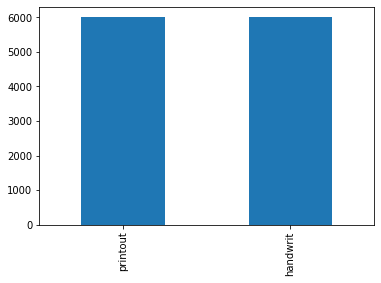

In [7]:
train['categories'].value_counts().plot.bar()

<AxesSubplot:>

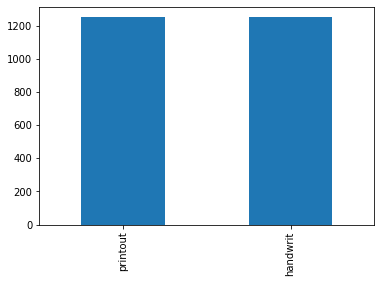

In [8]:
dev['categories'].value_counts().plot.bar()

# PREPARE TRAIN AND DEV SET

In [9]:
#Prepare train dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # dimesion reduction
    rotation_range=5,  # randomly rotate images in the range 5 degrees
    zoom_range = 0.1, # Randomly zoom image 10%
    width_shift_range=0.1,  # randomly shift images horizontally 10%
    height_shift_range=0.1,  # randomly shift images vertically 10%
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    "../input/writing/train", 
    x_col='filename',
    y_col='categories',
    target_size= (64,256),
    class_mode='categorical',
    batch_size=25,
    shuffle=False
)

Found 12000 validated image filenames belonging to 2 classes.


In [10]:

#Prepare dev dataset

validation_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = validation_datagen.flow_from_dataframe(
    dev, 
    "../input/writing/valid", 
    x_col='filename',
    y_col='categories',
    target_size=(64,256),
    class_mode='categorical',
    batch_size=25,
    shuffle=False
)

Found 2500 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


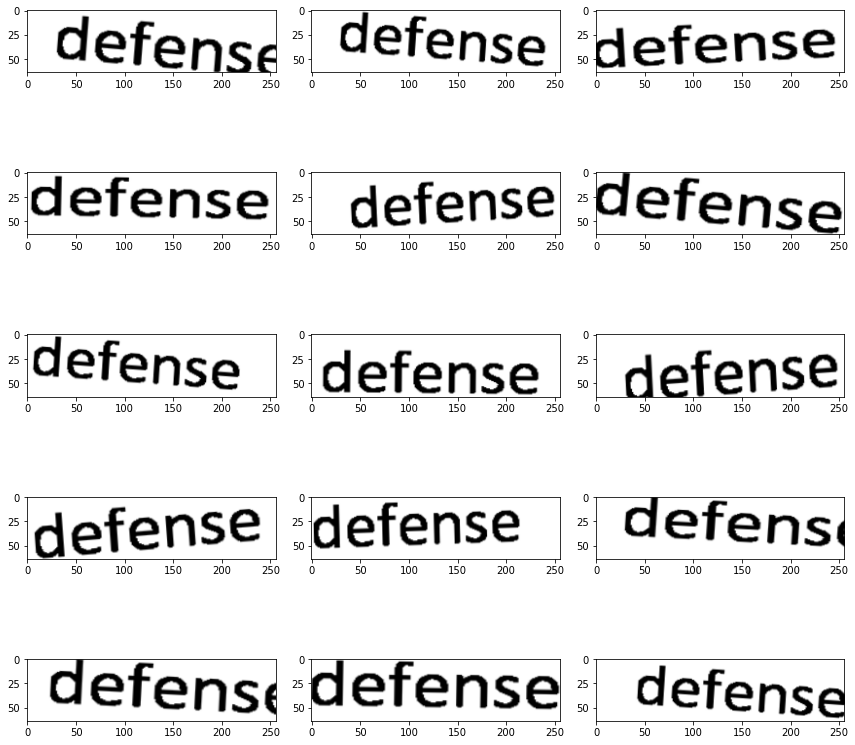

In [11]:
#An example from train data

example_df = train_label.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/writing/train", 
    x_col='filename',
    y_col='categories',
    target_size=(64,256),
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# CREATE MODEL

In [12]:
#Create Model

model = Sequential()

#conv1

model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = "Same", strides = (2,2), activation = "relu", input_shape = (64,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#conv2
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = "Same", strides = (1,1), activation = "relu", input_shape = (64,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#conv3
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "Same", strides = (1,1), activation = "relu", input_shape = (64,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#conv4
model.add(Conv2D(filters = 64, kernel_size = (1,1), padding = "Same", strides = (1,1), activation = "relu", input_shape = (64,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#FC1(Fully Connected) Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#FC2(Fully Connected) Layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics= tf.keras.metrics.CategoricalAccuracy())

model.summary()

2022-04-29 00:12:59.465947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 128, 8)        608       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 16)         0

2022-04-29 00:12:59.581114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 00:12:59.581913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 00:12:59.583062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 00:12:59.584225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# MODEL ARCHITECTURE

## Why RELU in Hidden Layer ?
- The main advantage of the ReLU function, which is often used in Convolutional Neural Network (CNN) and middleware, is that it does not activate all neurons at the same time. 
- So if a neuron produces a negative value, it means that it will not be activated. 
- This allows ReLU to work more efficiently and faster than the Hyperbolic Tangent and Sigmoid function.
- Therefore, ReLU is more preferred in multilayer neural networks.

## Why filters started at 8 and increasing per each CONV layer ?
- This is the first step process of extracting valuable feautres from an image
- CNN compute input images with using filters and review the images with scans the image. 
- The layers which close to input layer will less, which closeto ouput layer will learn more filters.
- İt must be multiples of 2

## Why ı use padding ?
- Use of Padding is increasing the model performance
- If you dont use, the volume will decrease after each layer and the ınfromatıons may delete quickly.

## Kernel Size
- It determıne heigh and width of Convolution window
- If ınput image larger than 128x128, start with 5x5 or 7x7 and decrease quickly and start work with 3x3. If not, stay with 3xor 1x1.
- In this picture, I also used 1x1 as my picture is equal to 128x128

## Strides
- It determines how many pixels the filter will slide over the main page.

## BatchNormalization
- Batch normalization is a larger that allows every layer of the network to do learning more independently
- Using Batch Normalization learning become efficient also it can be used as regulaziation to avoid overfitting of the model
- It is often placed just after defining the Sequential model and after the convolution layer.

## Pooling Layer
- It work on feature map separately to create new set.
- It used as 2x2 on 2x2 feature maps
- I used Max Pooling becasue ıt generally used on visual data

## Dropout Layer
- Since all parameters are occupied into FCL (Fully Connected Layer), it causes overfitting.
- Dropout is one of the techniquies that reduces overfitting.
- It should be 0.5-0.8 in hidden layer
- It should be around of 0.8 in input layer

## Flatten Layer
- It flatten the pooled of features into an input vector to processing in neural networks

## FCL (Fully Connected Layer)
- FCL looks like a regular neural network connecting all neurons and forms the last few layers in the network. 
- The output from flatten layer is fed to this FCL layer.

## Why RMSprop Optimazer ?
- I used the most used Adam optimizer, but the dev set loss was very high and I can't say that it improved the model performance very much, but RMSprop significantly increased the model performance. 
- When choosing an optimizer, I prefer different models starting from the most used ones, so I discover the most suitable optimizer algorithm for the model.

## Why Categorical Crossentropy Loss ? 
- It computes the cross-entropy loss between true labels and predicted labels. Thıs is most ımportant for us because predicted true label is more important for the model.
- We have two categories so should use this loss function

## Why Categorical Accuracy Metrics ?

- This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. 
* This frequency is ultimately returned as categorical accuracy: an idempotent operation that simply divides total by count.
- A metric is a function that is used to judge the performance of the model so this metric is more useable for us


In [13]:
epochs = 50  # for better result increase the epochs
batch_size = 64 #for better results you may  decrease the batch_size but training time will increase

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


callbacks = [earlystop, learning_rate_reduction]



# ReduceLRonPlateau
- Reduce learning rate when a metric has stopped improving.
- Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
- This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

# EarlyStopping
- Stop training when a monitored metric has stopped improving.
- Assuming the goal of a training is to minimize the loss.
- With this, the metric to be monitored would be 'loss', and mode would be 'min'. 
- A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable.
- Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.



In [15]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps=dev_label.shape[0]//batch_size,
                              steps_per_epoch=train_label.shape[0] // batch_size,
                             callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-29 00:13:02.280036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-29 00:13:05.032476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


187/187 [==============================] - 52s 237ms/step - loss: 0.7706 - categorical_accuracy: 0.7427 - val_loss: 36.0164 - val_categorical_accuracy: 0.4954
Epoch 2/50
187/187 [==============================] - 34s 181ms/step - loss: 0.3626 - categorical_accuracy: 0.8877 - val_loss: 11.9291 - val_categorical_accuracy: 0.4954
Epoch 3/50
187/187 [==============================] - 31s 164ms/step - loss: 0.2755 - categorical_accuracy: 0.9256 - val_loss: 5.6743 - val_categorical_accuracy: 0.5938
Epoch 4/50
187/187 [==============================] - 28s 148ms/step - loss: 0.2353 - categorical_accuracy: 0.9465 - val_loss: 0.8393 - val_categorical_accuracy: 0.8882
Epoch 5/50
187/187 [==============================] - 26s 140ms/step - loss: 0.1806 - categorical_accuracy: 0.9628 - val_loss: 0.9733 - val_categorical_accuracy: 0.9138
Epoch 6/50
187/187 [==============================] - 24s 129ms/step - loss: 0.2014 - categorical_accuracy: 0.9628 - val_loss: 0.3309 - val_categorical_accuracy: 0.

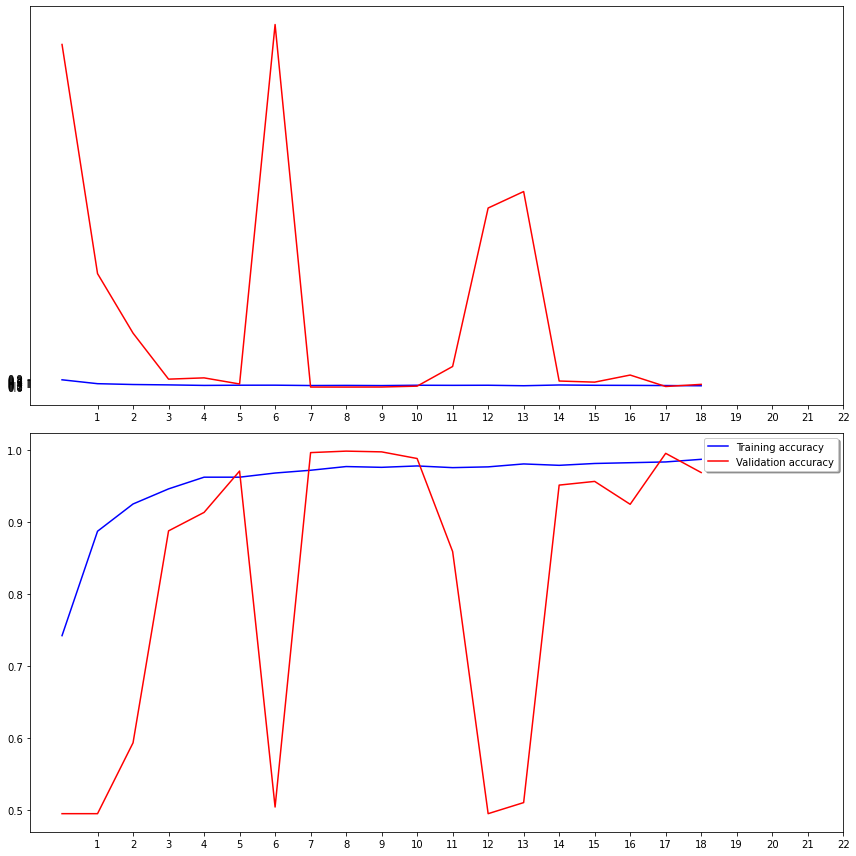

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 23, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 23, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [17]:
model.save_weights("model.h5")

# Prepare Testing Data

In [18]:
test_filenames = os.listdir("../input/writing/test")
test = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test.shape[0]

In [19]:
test

,filename
0,printout-7228.png
1,handwriting-18909.png
2,printout-6252.png
3,printout-6628.png
4,printout-6903.png
...,...
2495,printout-7191.png
2496,printout-6154.png
2497,handwriting-19585.png
2498,printout-6480.png


# Create Testing Generator

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test, 
    "../input/writing/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size= (64,256),
    batch_size=32,
    shuffle=False
)

Found 2500 validated image filenames.


# Predict

In [21]:
predict = model.predict_generator(test_generator)

test['predicted'] = np.argmax(predict, axis=-1)

# For categorical classification the prediction will come with probability of each category. 
# So we will pick the category that have the highest probability with numpy average max

label_map = dict((v,k) for k,v in train_generator.class_indices.items())

# We will convert the predict category back into our generator classes by using train_generator.class_indices. 
# It is the classes that image generator map while converting data into computer vision

test['predicted'] = test['predicted'].replace(label_map)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
test

,filename,predicted
0,printout-7228.png,printout
1,handwriting-18909.png,handwrit
2,printout-6252.png,printout
3,printout-6628.png,printout
4,printout-6903.png,printout
...,...,...
2495,printout-7191.png,printout
2496,printout-6154.png,printout
2497,handwriting-19585.png,handwrit
2498,printout-6480.png,printout


# Predicted Result with Images

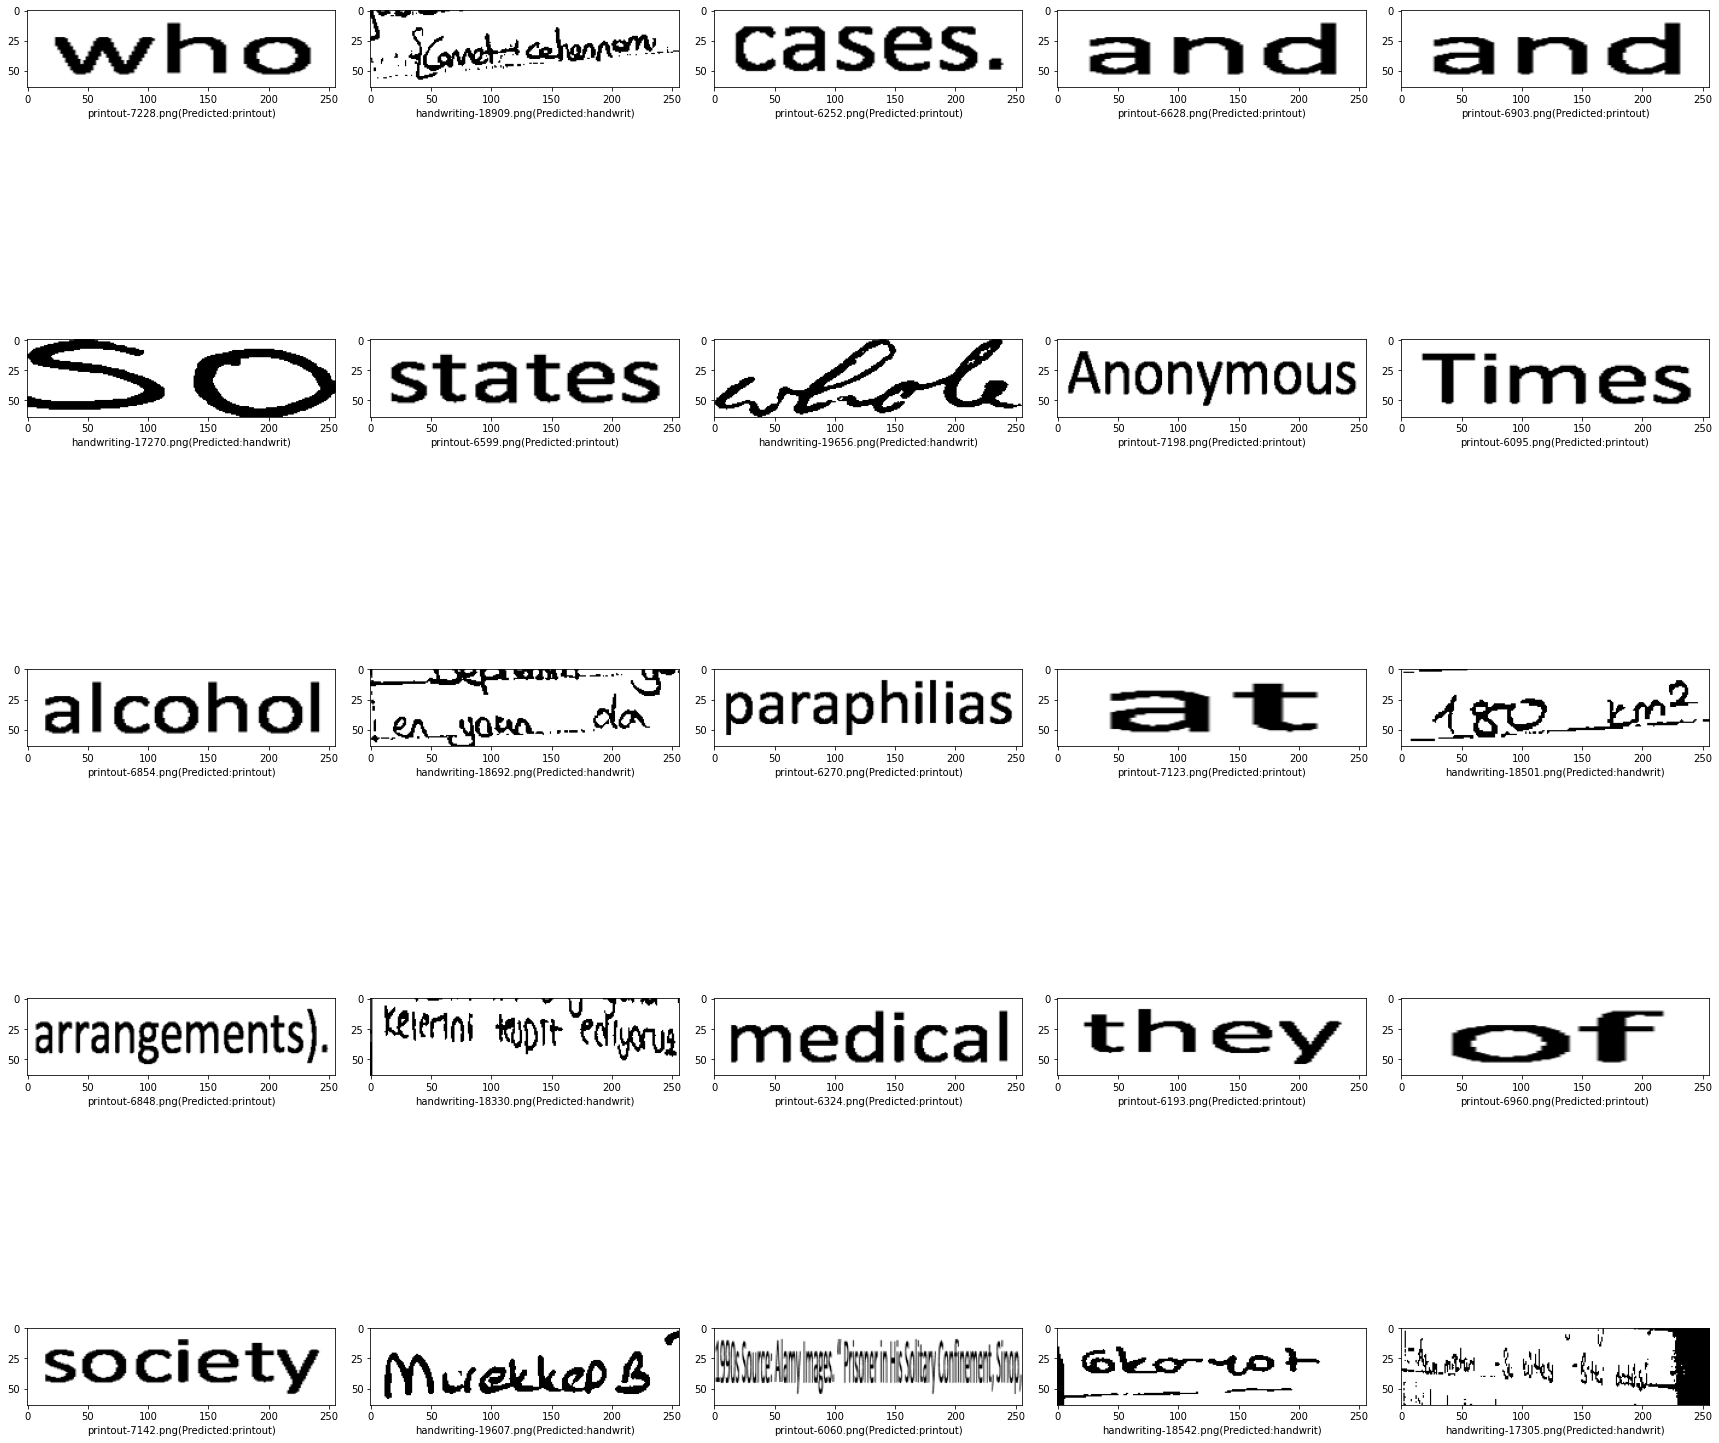

In [23]:
sample_test = test.head(25)
sample_test.head()
plt.figure(figsize=(24, 25))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("../input/writing/test/"+filename, target_size=(64,256))
    plt.subplot(5, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "Predicted:{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [110]:
folder = "../input/writing/test"

test_label = []                        

for img in os.listdir(folder):
    if 'handwrit' in img:            
        test_label.append((img, 1))
    elif "printout" in img:
        test_label.append((img, 0))

test_conf= pd.DataFrame(test_label)
test_conf= test_conf.rename(columns={0:"filenames", 1: "Real_Label"}) 
test_conf= test_conf.drop(labels=["filenames"], axis = 1)
test_conf = test_conf.reset_index(drop=True)
test_conf['Predicted_Label'] = test['predicted'].replace(label_map)

test_conf['Real_Label'] = test_conf['Real_Label'].replace({ 'handwrit': 1, 'printout': 0 })
test_conf['Predicted_Label'] = test_conf['Predicted_Label'].replace({ 'handwrit': 1, 'printout': 0 })
test_conf

,Real_Label,Predicted_Label
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
2495,0,0
2496,0,0
2497,1,1
2498,0,0


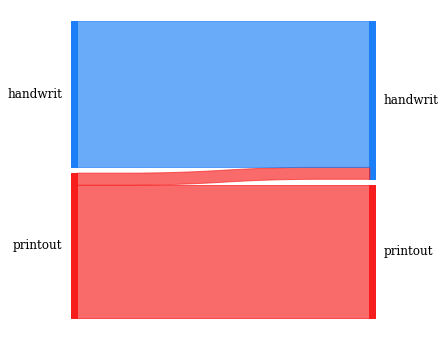

In [120]:
test_conf1= pd.DataFrame(test_label)
test_conf1= test_conf1.rename(columns={0:"filenames", 1: "Real_Label"}) 
test_conf1= test_conf1.drop(labels=["filenames"], axis = 1)
test_conf1 = test_conf1.reset_index(drop=True)
test_conf1['Predicted_Label'] = test['predicted'].replace(label_map)
test_conf1["Real_Label"] = test_conf1["Real_Label"].replace({0: 'printout', 1: 'handwrit'}) 

colors = {
    "printout": "#f71b1b",
    "handwrit": "#1b7ef7",

}

sankey(test_conf1["Real_Label"], test_conf1["Predicted_Label"], aspect=20, colorDict=colors, fontsize=12)

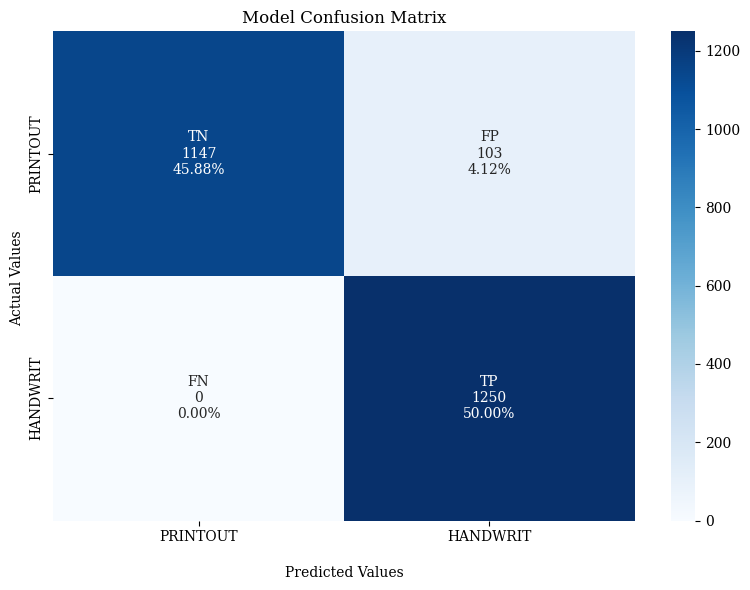

In [121]:
Real_Label = test_conf['Real_Label']
Predicted_Label = test_conf['Predicted_Label']

matrix = confusion_matrix(Real_Label,Predicted_Label)

figure(figsize=(8, 6), dpi=100)

group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title("Model Confusion Matrix")
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


ax.xaxis.set_ticklabels(['PRINTOUT','HANDWRIT'])
ax.yaxis.set_ticklabels(['PRINTOUT','HANDWRIT'])

plt.tight_layout()
plt.show()

In [29]:
print(classification_report(Real_Label, Predicted_Label))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1250
           1       0.92      1.00      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [51]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(Real_Label, Predicted_Label)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.9588


In [52]:
fpr, tpr, thresholds = roc_curve(Real_Label, Predicted_Label)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds= precision_recall_curve(Real_Label, Predicted_Label)
auc_score = auc(recall, precision)
f1 = f1_score(Real_Label, Predicted_Label)

# PRECISION / RECALL

MODEL: f1=0.960 auc=0.962


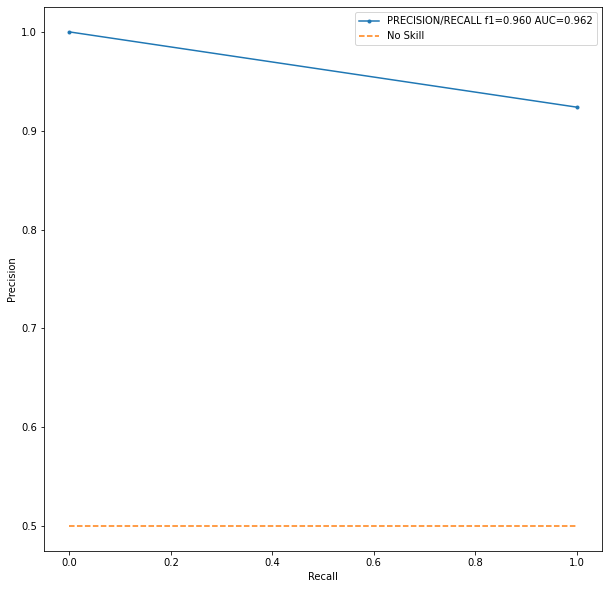

In [53]:
no_skill = len(Real_Label[Real_Label==1]) / len(Real_Label)

plt.figure(figsize=(10, 10))

print('MODEL: f1=%.3f auc=%.3f' % (f1, auc_score))

plt.plot(recall, precision, marker='.', label='PRECISION/RECALL f1=%.3f AUC=%.3f' % (f1, auc_score))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

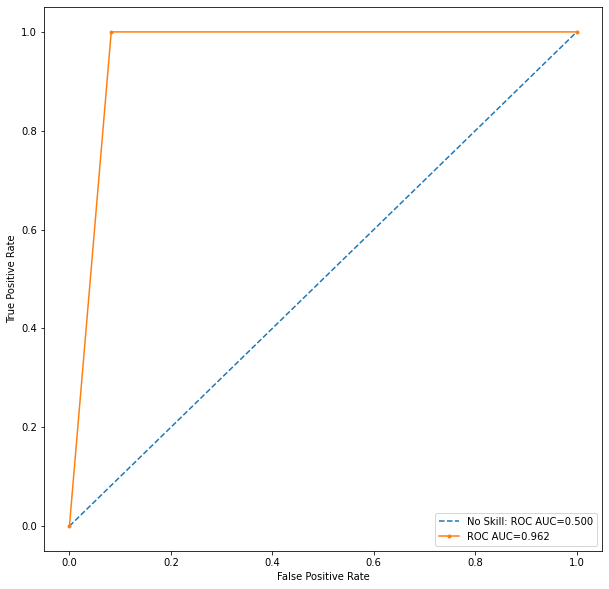

In [54]:
ns_probs = [0 for _ in range(len(Predicted_Label))]
ns_auc = roc_auc_score(Predicted_Label, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(Predicted_Label, ns_probs)

plt.figure(figsize=(10, 10))

plt.plot(ns_fpr, ns_tpr, linestyle='--', label="No Skill: ROC AUC=%.3f" % (ns_auc))
plt.plot(fpr, tpr, marker='.', label='ROC AUC=%.3f' % (auc_score))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [78]:
test_label= pd.DataFrame(test_label)
test_label= test_label.rename(columns={0:"filenames", 1: "categories"})
test_label["categories"] = test_label["categories"].replace({0: 'printout', 1: 'handwrit'}) 
test_label

,filenames,categories
0,printout-7228.png,printout
1,handwriting-18909.png,handwrit
2,printout-6252.png,printout
3,printout-6628.png,printout
4,printout-6903.png,printout
...,...,...
2495,printout-7191.png,printout
2496,printout-6154.png,printout
2497,handwriting-19585.png,handwrit
2498,printout-6480.png,printout


# MODEL EVALUATE

In [81]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = validation_datagen.flow_from_dataframe(
    test_label, 
    "../input/writing/test", 
    x_col='filenames',
    y_col='categories',
    target_size=(64,256),
    class_mode='categorical',
    batch_size=25,
    shuffle=False
)

Found 2500 validated image filenames belonging to 2 classes.


In [102]:
model.evaluate(test_generator,batch_size=64, callbacks=callbacks, verbose = 1, steps=500)

500/500 [==============================] - 3s 6ms/step - loss: 0.4977 - categorical_accuracy: 0.9588


[0.4976504445075989, 0.9588000178337097]

# CONCLUSION

### Firstly, ı see the dev set accuracy and loss better than training set. So Why ?

- We may have small validation set (2500)
- We may have highly unbalanced data in val set but ı do not think so.
- We use regularization methods such as  Dropout, while model calculate training accuracy it process through regularized model but when it test accuracy on val set, it process your data trough un regularized model. Regularization introduces some noise in loss value during training, because of this training accuracy decreases than expected, but while evaluating the model, model doesn’t use regularization hence no noise, val accuracy doesn’t decrease.

### PRECISION / RECALL , F1 Score

- It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.  This is important for us because the important thing in the model is the true predictive and our precision recall score is good.
- But dont forget, reviewing bot precision and recall is useful in cases where there is an inbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0 ) and only a few examples. So thıs graph may not useful for us.
- F1 Score calculates mean of the precision and recall.

### AUC/ROC CURVE

- Roc curve is an evaluation metric for classification problems. It is a probablity curve that plot the TPR (True Positive Rate) against FPR (False Positive Rate) at various threshold values and essentially separates the signal from the noise.
- The AUC is the meause of the ablity of classifier distinguish between classes and is used as a summary of the ROC curve.
- ROC Curves should be used when there are queal numbers of observations for each class. So, this graph more usuable for us than Precısıon/Recall curve.
- ROC/AUC scores seems good so we may say the model can predictive good

### Confusıon Matrix

- When we review the confusıon matrix, we can see the good result there is only FP (False Positive) values have problems. So, our model saw printout data as  handwrit data.
- Actually this is normal. Because some data are like printout data or noisy data reason for this results.

- We can say the development data of the model should be increased and diversity should be introduced. Also, different methods can be tried by changing the parameters of the model.

